In [108]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import networkx as nx
import random
from skimage.util import view_as_blocks

Number of agents: 100
Patch Size: (64, 64, 1)


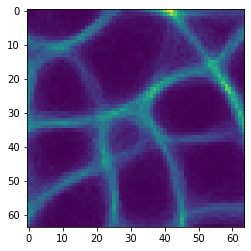

In [183]:
N_AGENTS = 100
TRACE = np.load('trace.npy')
G = nx.Graph()
patch = np.copy(TRACE[0:64,0:64,:])
STOCHASTIC_SAMPLING = 0
DOMAIN_SIZE = [16,16]
rng = default_rng()

print('Number of agents:', N_AGENTS)
print('Patch Size:', patch.shape)
plt.imshow(patch)

In [184]:
patch.shape

(64, 64, 1)

In [185]:
agent_field = np.zeros((N_AGENTS, 4))
agent_field[:, 0] = rng.uniform(low=0.0, high=DOMAIN_SIZE[0], size=agent_field.shape[0])
agent_field[:, 1] = rng.uniform(low=0.0, high=DOMAIN_SIZE[1], size=agent_field.shape[0])
agent_field[:, 2] = rng.uniform(low=0.0, high=2.0*np.pi, size=agent_field.shape[0])
agent_field[:, 3] = 1.0
print(agent_field[0, :])

[15.45156777 12.27085912  0.75220186  1.        ]


In [186]:
import math
import random

def world_to_grid_2D(pos_world, size_world, size_grid):
    return (pos_world / size_world) * (size_grid)

def angle_to_dir_2D(angle):
    return np.array([math.cos(float(angle)), math.sin(float(angle))])

def custom_mod(a, b):
    return a - b * math.floor(a / b)

In [187]:
## Main simulation & vis loop
sense_distance = 1.0
sense_angle = 2.5
step_size = 0.1
attenuation = 0.95
weight_multiplier = 0.1
steering_rate = 0.5

# agent_field.from_numpy(agents)

In [188]:
# import queue
# angle_queue = queue.Queue()
# pos_dict = {}
# def propagation_step(sense_distance, sense_angle, steering_rate, step_size, weight_multiplier, stochastic_sampling, m):
#     k = m
#     for agent in range(agent_field.shape[0]):
#         pos1, pos2, angle, weight = agent_field[0]
#         pos = [pos1, pos2]
#         dir_fwd = angle_to_dir_2D(angle)
#         angle_mut = angle + (random.random() - 0.5) * sense_angle
#         dir_mut = angle_to_dir_2D(angle_mut)
        
#         trace_fwd = world_to_grid_2D(pos + sense_distance * dir_fwd, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
#         trace_mut = world_to_grid_2D(pos + sense_distance * dir_mut, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
#         deposit_fwd = TRACE[trace_fwd[0].astype(int)][trace_fwd[1].astype(int)][0]
#         deposit_mut = TRACE[trace_mut[0].astype(int)][trace_mut[1].astype(int)][0]

#         angle_new = 0.0
#         if stochastic_sampling:
#             angle_new = (angle) if (random.random() < deposit_fwd / (deposit_fwd + deposit_mut)) else (steering_rate * angle_mut + (1.0-steering_rate) * angle)
#         else:
#             angle_new = (angle) if (deposit_fwd > deposit_mut) else (steering_rate * angle_mut + (1.0-steering_rate) * angle)
        
#         if(G.number_of_nodes() == 0):
#             G.add_node(k)
#             angle_queue.put(angle_new)
#         else:
#             if abs(angle_new - angle_queue.queue[0]) > 0.26:
#                 G.add_node(k)
#                 G.add_edge(list(G.nodes())[-1], list(G.nodes())[-2])
                
#                 if(angle_queue.qsize() == 3):
#                     angle_queue.get()
#                 angle_queue.put(angle_new)
                
#         pos_dict[agent]=(pos1, pos2)
#         dir_new = angle_to_dir_2D(angle_new)
#         pos_new = pos + step_size * dir_new
 
#         pos_new[0] = custom_mod(pos_new[0], DOMAIN_SIZE[0])
#         pos_new[1] = custom_mod(pos_new[1], DOMAIN_SIZE[1])

#         agent_field[0][0] = pos_new[0]
#         agent_field[0][1] = pos_new[1]
#         agent_field[0][2] = angle_new
#         k = k + 1
#     m = m + k
#     return

# for i in range(10):
#     propagation_step(sense_distance, sense_angle, steering_rate, step_size, weight_multiplier, STOCHASTIC_SAMPLING, m)

In [189]:
import queue
angle_queue = queue.Queue()
pos_dict = {}
m = 0

for i in range(1):
    k = m
    for agent in range(agent_field.shape[0]):
        pos1, pos2, angle, weight = agent_field[0]
        pos = [pos1, pos2]
        dir_fwd = angle_to_dir_2D(angle)
        angle_mut = angle + (random.random() - 0.5) * sense_angle
        dir_mut = angle_to_dir_2D(angle_mut)
        
        trace_fwd = world_to_grid_2D(pos + sense_distance * dir_fwd, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
        trace_mut = world_to_grid_2D(pos + sense_distance * dir_mut, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
        deposit_fwd = patch[trace_fwd[0].astype(int)][trace_fwd[1].astype(int)][0]
        deposit_mut = patch[trace_mut[0].astype(int)][trace_mut[1].astype(int)][0]
        
        angle_new = 0.0
        if STOCHASTIC_SAMPLING:
            angle_new = (angle) if (random.random() < deposit_fwd / (deposit_fwd + deposit_mut)) else (steering_rate * angle_mut + (1.0-steering_rate) * angle)
        else:
            angle_new = (angle) if (deposit_fwd > deposit_mut) else (steering_rate * angle_mut + (1.0-steering_rate) * angle)
        
        if(G.number_of_nodes() == 0):
            G.add_node(k)
            angle_queue.put(angle_new)
        else:
            if abs(angle_new - angle_queue.queue[0]) > 0.26:
                G.add_node(k)
                G.add_edge(list(G.nodes())[-1], list(G.nodes())[-2])
                
                if(angle_queue.qsize() == 3):
                    angle_queue.get()
                angle_queue.put(angle_new)
                
        pos_dict[k]=(pos1, pos2)
        dir_new = angle_to_dir_2D(angle_new)
        pos_new = pos + step_size * dir_new
 
        pos_new[0] = custom_mod(pos_new[0], DOMAIN_SIZE[0])
        pos_new[1] = custom_mod(pos_new[1], DOMAIN_SIZE[1])

        agent_field[0][0] = pos_new[0]
        agent_field[0][1] = pos_new[1]
        agent_field[0][2] = angle_new
        k = k + 1
    m = m + k

In [190]:
G.edges

EdgeView([(0, 1), (1, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 21), (21, 22), (22, 23), (23, 33), (33, 34), (34, 35), (35, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 59), (59, 60), (60, 61), (61, 64), (64, 65), (65, 66), (66, 67), (67, 70), (70, 71), (71, 72), (72, 75), (75, 76), (76, 77), (77, 88), (88, 97), (97, 98), (98, 99)])

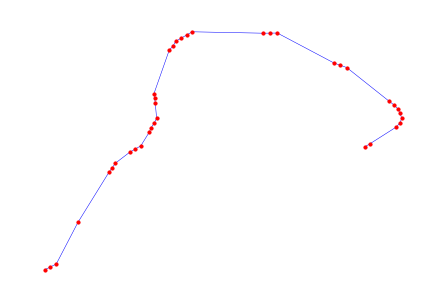

In [191]:
import matplotlib.pyplot as plt
nx.draw(G, pos=pos_dict,
        arrowstyle='->', 
        arrowsize=20, 
        width=0.5,
        with_labels=False, 
        node_size=10, 
        node_color='red',
        edge_color='blue')
plt.savefig("graph.png", dpi=1000)